In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#Used for creating global parameters such as inflation, gdp growth, and unemployment rate
#Also used to store the investor's parameters such as repayment caps.

class Year:
    def __init__(self, initial_gdp_growth, initial_inflation_rate,initial_unemployment_rate,initial_isa_cap,
                 initial_isa_threshold, num_years, senior_debt_threshold, mezzanine_debt_threshold):
        self.year_count = 1
        self.gdp_growth = initial_gdp_growth
        self.stable_gdp_growth = initial_gdp_growth
        self.inflation_rate = initial_inflation_rate
        self.stable_inflation_rate = initial_inflation_rate
        self.unemployment_rate = initial_unemployment_rate
        self.stable_unemployment_rate = initial_unemployment_rate
        self.isa_cap = initial_isa_cap
        self.isa_threshold = initial_isa_threshold
        self.deflator = 1
        self.hit_senior_cap = False
        self.hit_mezzanine_cap = False
        self.senior_payments = [0] * num_years
        self.mezzanine_payments = [0] * num_years
        self.remainder_payments = [0] * num_years
        self.senior_real_payments = [0] * num_years
        self.mezzanine_real_payments = [0] * num_years
        self.remainder_real_payments = [0] * num_years
        self.senior_debt_threshold = senior_debt_threshold
        self.mezzanine_debt_threshold = mezzanine_debt_threshold

    def next_year(self):
        self.year_count = self.year_count + 1
        self.gdp_growth = self.stable_gdp_growth * .33 + self.gdp_growth * .5 + np.random.normal(0, .02)
        self.inflation_rate = self.stable_inflation_rate * .45 + self.inflation_rate * .5 + np.random.normal(0, .01)
        self.unemployment_rate = self.stable_unemployment_rate * .33 + self.unemployment_rate * .25 + np.random.lognormal(0, 1) / 100
        self.isa_cap = self.isa_cap * (1 + self.inflation_rate)
        self.isa_threshold = self.isa_threshold * (1 + self.inflation_rate)
        self.deflator = self.deflator * (1 + self.inflation_rate)
        self.isa_cap = self.isa_cap * (1 + self.inflation_rate)
        if self.hit_senior_cap == False:
          self.senior_debt_threshold = self.senior_debt_threshold * (1 + self.inflation_rate)
        if self.hit_senior_cap == False:
          self.mezzanine_debt_threshold = self.mezzanine_debt_threshold * (1 + self.inflation_rate)



In [ ]:
#Used for each student to store path dependent earnings and whether the student
#Also to evaluate if student has finished repayment

class Student:
    def __init__(self, degree, num_years):
        self.degree = degree
        self.num_years = num_years
        self.earnings_power = 0
        self.earnings = [0] * num_years
        self.payments = [0] * num_years
        self.real_payments = [0] * num_years
        self.is_graduated = False
        self.is_employed = False
        self.is_home = False
        self.years_paid = 0
        self.hit_cap = False
        self.years_experience = 0


In [ ]:
# Assigned only once to each student upon graduation
class Degree:
    def __init__(self, name, mean_earnings, stdev, experience_growth, years_to_complete,home_prob):
        self.name = name
        self.mean_earnings = mean_earnings
        self.stdev = stdev
        self.experience_growth = experience_growth
        self.years_to_complete = years_to_complete
        self.home_prob = home_prob

In [ ]:
#Launches a single path dependent cohort and iterates through each year to assign
#both a set of macro variables for the year and a set of per student variables
#These variables are then stored as a dataframe of annual payments
#There is a bit of extra logic to store real and nominal variables during the
#simulation so I can be lazy

def simulate(students,year,num_years,isa_percentage,limit_years,gamma=False):
    for i in range(num_years):
        for student in students:
            if i < student.degree.years_to_complete:
                continue
            if i == student.degree.years_to_complete:
                student.is_graduated = True
                student.is_home = np.random.binomial(1,student.degree.home_prob) == 1
                if gamma:
                  student.earnings_power = max(0, np.random.gamma(student.degree.mean_earnings, student.degree.stdev))
                else:
                  student.earnings_power = max(0, np.random.normal(student.degree.mean_earnings, student.degree.stdev))
                if student.is_home:
                  if gamma:
                    student.earnings_power = max(0, np.random.gamma(67600/4761,4761/26))
                  else:
                    student.earnings_power = max(0, np.random.normal(2600,690))
            if year.unemployment_rate < 1:
              student.is_employed = np.random.binomial(1,year.unemployment_rate) == 0
            else:
              student.is_employed = False
            if student.is_employed:
                student.earnings[i] = student.earnings_power * year.deflator * (1 + student.degree.experience_growth) ** student.years_experience
                student.years_experience = student.years_experience + 1
                excess = max(0, student.earnings[i] - year.isa_threshold)
                if excess > 0:
                    student.years_paid = 1 + student.years_paid

                    if student.years_paid > limit_years:
                        continue
                    if student.hit_cap:
                        continue
                    if (np.sum(student.payments) + isa_percentage * student.earnings[i]) > year.isa_cap:
                        student.payments[i] = year.isa_cap - np.sum(student.payments)
                        student.real_payments[i] = (year.isa_cap - np.sum(student.payments)) / year.deflator
                        student.hit_cap = True
                    else:
                        student.payments[i] = isa_percentage * student.earnings[i]
                        student.real_payments[i] = isa_percentage * student.earnings[i] / year.deflator

                    if (year.hit_mezzanine_cap == True) & (year.hit_senior_cap == True):
                        year.remainder_payments[i] = year.remainder_payments[i] + student.payments[i]
                        year.remainder_real_payments[i] = year.remainder_real_payments[i] + student.real_payments[i]
                    elif (year.hit_mezzanine_cap == False) & (year.hit_senior_cap == True):
                        if np.sum(year.mezzanine_payments) + student.payments[i] <= year.mezzanine_debt_threshold:
                            year.mezzanine_payments[i] = year.mezzanine_payments[i] + student.payments[i]
                            year.mezzanine_real_payments[i] = year.mezzanine_real_payments[i] + student.real_payments[i]
                        else:
                            year.remainder_payments[i] = student.payments[i] - min(student.payments[i], mezzanine_debt_threshold - np.sum(year.mezzanine_payments))
                            year.remainder_real_payments[i] = student.real_payments[i] - min(student.payments[i], mezzanine_debt_threshold - np.sum(year.mezzanine_payments))
                            year.mezzanine_payments[i] = year.mezzanine_payments[i] + min(student.payments[i], mezzanine_debt_threshold - np.sum(year.mezzanine_payments))
                            year.mezzanine_real_payments[i] = year.mezzanine_real_payments[i] + min(student.real_payments[i], mezzanine_debt_threshold - np.sum(year.mezzanine_payments))
                            year.hit_mezzanine_cap = True

                    else:
                        if np.sum(year.senior_payments) + student.payments[i] <= year.senior_debt_threshold:
                            year.senior_payments[i] = year.senior_payments[i] + student.payments[i]
                            year.senior_real_payments[i] = year.senior_real_payments[i] + student.real_payments[i]
                        else:
                            year.mezzanine_payments[i] = student.payments[i] - min(student.payments[i], year.senior_debt_threshold - np.sum(year.senior_payments))
                            year.mezzanine_real_payments[i] = student.real_payments[i] - min(student.payments[i], year.senior_debt_threshold - np.sum(year.senior_payments))
                            year.senior_payments[i] = year.senior_payments[i] + min(student.payments[i], year.senior_debt_threshold - np.sum(year.senior_payments))
                            year.senior_real_payments[i] = year.senior_real_payments[i] + min(student.real_payments[i], year.senior_debt_threshold - np.sum(year.senior_payments))
                            year.hit_senior_cap = True




            else:
                student.years_experience = max(0,student.years_experience-3)

        year.next_year()
    data = {
        'Student': students,
        'Degree': [student.degree for student in students],
        'Earnings': [student.earnings for student in students],
        'Payments': [student.payments for student in students],
        'Real_Payments': [student.real_payments for student in students],
        'Cohort_Senior_Payments': year.senior_payments,
        'Cohort_Senior_Real_Payments': year.senior_real_payments,
        'Cohort_Mezzanine_Payments': year.mezzanine_payments,
        'Cohort_Mezzanine_Real_Payments': year.mezzanine_real_payments,
        'Cohort_Remainder_Payments': year.remainder_payments,
        'Cohort_Remainder_Real_Payments': year.remainder_real_payments
    }
    #df = pd.DataFrame(data)
    return data

In [ ]:
#Baseline earnings and degree probability

degrees = [
    Degree(name='BA',mean_earnings=41300,stdev=13000,experience_growth= .04,years_to_complete=5,home_prob=.0),
    Degree(name='MA',mean_earnings=46709,stdev=15000,experience_growth= .04,years_to_complete=7,home_prob=.0),
    Degree(name='VOC',mean_earnings=31500,stdev=8000,experience_growth= .04,years_to_complete=5,home_prob=.0),
    Degree(name='NA',mean_earnings=2200,stdev=8000,experience_growth= .01,years_to_complete=4,home_prob=.8),
]

probs = [.43,.23,.25,.09]

In [ ]:
#Block of code to actually launch the simulations

#Set some empty lists because this is hacky
total_payment = {}
total_payment_2 = {}
senior_payment = {}
mezzanine_payment = {}
remainder_payment = {}
df_list = []

#Declare your hyperparameters
num_students = 100
num_sims = 100
num_years = 25

#Set contract parameters
limit_years = 10
price_per_student = 30000
initial_isa_cap = price_per_student * 3
initial_isa_threshold = 30000
isa_percentage = .14

#Set macro variables
initial_gdp_growth = .01
initial_unemployment_rate = .04
initial_inflation_rate = .02

#Set seniority structure
total_debt = num_students * price_per_student
senior_debt = total_debt * 0.7
mezzanine_debt = total_debt * 0.2
remainder_debt = total_debt * 0.1
senior_debt_threshold = senior_debt * 1.5
mezzanine_debt_threshold = mezzanine_debt * 2

#Run num_sims amount of simulations
for trial in range(num_sims):
    #Initialize year class
    year = Year(initial_gdp_growth=initial_gdp_growth, initial_inflation_rate=initial_inflation_rate,
                initial_unemployment_rate=initial_unemployment_rate,initial_isa_cap=initial_isa_cap,initial_isa_threshold=initial_isa_threshold,
                num_years=num_years,
                senior_debt_threshold=senior_debt_threshold, mezzanine_debt_threshold=mezzanine_debt_threshold)

    #Assign degrees to each student
    test_array = np.array([np.random.multinomial(1,probs) for j in range(num_students)])
    degree_labels = np.array(degrees)[test_array.argmax(axis=1)]
    students = []
    for _ in range(num_students):
        students.append(Student(degree_labels[_],num_years))

    #run the simulation and store the relevant details in a poorly named list of data frames
    df_list.append(simulate(students=students,year=year,num_years=num_years,limit_years=limit_years,isa_percentage=isa_percentage, gamma=False))

    #Extract the relevant details to better named dictionaries
    #Each simulation is the key and the repayment data is the value
    total_payment[trial] = np.sum(pd.DataFrame(df_list[trial]['Real_Payments']))
    senior_payment[trial] = df_list[trial]['Cohort_Senior_Real_Payments']
    mezzanine_payment[trial] = df_list[trial]['Cohort_Mezzanine_Real_Payments']
    remainder_payment[trial] = df_list[trial]['Cohort_Remainder_Real_Payments']
    #total_payment_2[trial] = np.sum(df_list[trial]['Cohort_Senior_Payments'])

#Take the dictionaries and calculate relevant summary statistics
payments_df = pd.DataFrame(total_payment)
average_total_payment = np.sum(payments_df).mean()
average_duration = np.dot((payments_df.index + 1),payments_df / np.sum(payments_df)).mean()
IRR = np.log(average_total_payment / total_debt) / average_duration

payments_df_senior = pd.DataFrame(senior_payment)
average_total_payment_senior = np.sum(payments_df_senior).mean()
average_duration_senior = np.dot((payments_df_senior.index +1),payments_df_senior / np.sum(payments_df_senior)).mean()
IRR_senior = np.log(average_total_payment_senior / senior_debt) / average_duration_senior + initial_inflation_rate

min_total_payment_senior = np.sum(payments_df_senior).min()
IRR_senior_min = np.log(min_total_payment_senior / senior_debt) / average_duration_senior + initial_inflation_rate

fifth_total_payment_senior = np.sum(payments_df_senior).quantile(.05)
IRR_senior_fifth = np.log(fifth_total_payment_senior / senior_debt) / average_duration_senior + initial_inflation_rate

payments_df_mezzanine = pd.DataFrame(mezzanine_payment) + 1
average_total_payment_mezzanine = np.sum(payments_df_mezzanine).mean()
average_duration_mezzanine = np.dot((payments_df_mezzanine.index +1),payments_df_mezzanine / np.sum(payments_df_mezzanine)).mean()
IRR_mezzanine = np.log(average_total_payment_mezzanine / mezzanine_debt) / average_duration_mezzanine + initial_inflation_rate

payments_df_remainder = pd.DataFrame(remainder_payment) + 1
average_total_payment_remainder = np.sum(payments_df_remainder).mean()
average_duration_remainder = np.dot((payments_df_remainder.index +1),payments_df_remainder / np.sum(payments_df_remainder)).mean()
IRR_remainder = np.log(average_total_payment_remainder / remainder_debt) / average_duration_remainder + initial_inflation_rate

quantile_total_payment = np.sum(payments_df).quantile(.75)
IRR_quantile_75 = np.log(quantile_total_payment / total_debt) / average_duration
quantile_total_payment = np.sum(payments_df).quantile(.25)
IRR_quantile_25 = np.log(quantile_total_payment / total_debt) / average_duration
quantile_total_payment = np.sum(payments_df).quantile(.0)
IRR_quantile_0 = np.log(quantile_total_payment / total_debt) / average_duration
quantile_total_payment = np.sum(payments_df).quantile(1)
IRR_quantile_100 = np.log(quantile_total_payment / total_debt) / average_duration

In [ ]:
#Print the values for summarizing a scenario
print('Rate of return: %.3f'%(IRR))
print('75th percentile - 25th percentile: %.3f'%(IRR_quantile_75 - IRR_quantile_25))
print('Min: %.3f'%(IRR_quantile_0))
print('Max: %.3f'%(IRR_quantile_100))

Rate of return: 0.056
75th percentile - 25th percentile: 0.007
Min: 0.043
Max: 0.065


In [ ]:
average_total_payment

6854608.114448208

In [ ]:
#Below here is a bit organized for calculating sensitivities and extra stored scenarios

In [ ]:
#Conservative scenario with immigration

degrees = [
    Degree(name='BA',mean_earnings=41300,stdev=13000,experience_growth= .04,years_to_complete=5,home_prob=.0),
    Degree(name='MA',mean_earnings=46700,stdev=15000,experience_growth= .04,years_to_complete=7,home_prob=.0),
    Degree(name='VOC',mean_earnings=31500,stdev=8000,experience_growth= .04,years_to_complete=5,home_prob=.0),
    Degree(name='NA',mean_earnings=2200,stdev=8000,experience_growth= .01,years_to_complete=4,home_prob=.8),
]

probs = [.3,.1,.1,.5]

In [ ]:
#Conservative scenario

degrees = [
    Degree(name='BA',mean_earnings=41300,stdev=13000,experience_growth= .04,years_to_complete=5,home_prob=.0),
    Degree(name='MA',mean_earnings=46700,stdev=15000,experience_growth= .04,years_to_complete=7,home_prob=.0),
    Degree(name='VOC',mean_earnings=31500,stdev=8000,experience_growth= .04,years_to_complete=5,home_prob=.0),
    Degree(name='NA',mean_earnings=2200,stdev=8000,experience_growth= .01,years_to_complete=4,home_prob=.8),
]

probs = [.3,.1,.4,.2]

In [ ]:
#Optimistic scenario

degrees = [
    Degree(name='BA',mean_earnings=41300,stdev=13000,experience_growth= .04,years_to_complete=5,home_prob=.0),
    Degree(name='MA',mean_earnings=46700,stdev=15000,experience_growth= .04,years_to_complete=7,home_prob=.0),
    Degree(name='VOC',mean_earnings=31500,stdev=8000,experience_growth= .04,years_to_complete=5,home_prob=.0),
    Degree(name='NA',mean_earnings=2200,stdev=8000,experience_growth= .01,years_to_complete=4,home_prob=.8),
]

probs = [.625,.325,.025,.025]

In [ ]:
#Too complicated gamma distribution

degrees = [
    Degree(name='BA',mean_earnings=173889/7225,stdev=722500/417,experience_growth= .04,years_to_complete=4,home_prob=.2),
    Degree(name='MA',mean_earnings=2181730681 / 144000000,stdev=144000000 / 46709,experience_growth= .045,years_to_complete=6,home_prob=.2),
    Degree(name='NA',mean_earnings=484/25,stdev=12500/11,experience_growth= .04,years_to_complete=4,home_prob=.8),
]

probs = [.528,.372,.2]

In [ ]:
#Print annual payments indexed by year of remayment

for i in range(num_years):
  print(payments_df.T.describe()[i])

count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: 0, dtype: float64
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: 1, dtype: float64
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: 2, dtype: float64
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: 3, dtype: float64
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: 4, dtype: float64
count       100.000000
mean     263903.725431
std       31665.300437
min      193845.831941
25%      241338.693079
50%      266691.061283
75%      286309.836875
max      336619.818893
Name: 5, dtype: float64
count       100.000000
mean     282082.976420
std       34507.564921
min

In [ ]:
# Calculate sensitivity

degrees = [
    Degree(name='BA',mean_earnings=41300,stdev=13000,experience_growth= .04,years_to_complete=4,home_prob=.2),
    Degree(name='MA',mean_earnings=46709,stdev=15000,experience_growth= .045,years_to_complete=6,home_prob=.2),
    Degree(name='NA',mean_earnings=2200,stdev=8000,experience_growth= .04,years_to_complete=4,home_prob=.8),
]

probs = [.528,.272,.2]

num_students = 120
num_sims = 100
initial_unemployment_rate = .04
initial_inflation_rate = .02


limit_years_range = np.linspace(10,20,3)
initial_isa_cap_range = np.linspace(56220,206220,3)
initial_isa_threshold_range = np.linspace(27000,32000,2)
isa_percentage_range = np.linspace(.14,.18,3)

simulation_results = []
for initial_isa_cap in initial_isa_cap_range:
  for initial_isa_threshold in initial_isa_threshold_range:
    for limit_years in limit_years_range:
      num_years = round(limit_years)+8
      for isa_percentage in isa_percentage_range:
        df_list = []
        total_payment = {}
        for trial in range(num_sims):
          year = Year(initial_gdp_growth=.01, initial_inflation_rate=initial_inflation_rate,
                      initial_unemployment_rate=.04,initial_isa_cap=60000,initial_isa_threshold=27000,
                      num_years=num_years,
                      senior_debt_threshold=senior_debt_threshold, mezzanine_debt_threshold=mezzanine_debt_threshold)

          test_array = np.array([np.random.multinomial(1,probs) for j in range(num_students)])
          degree_labels = np.array(degrees)[test_array.argmax(axis=1)]
          students = []
          for _ in range(num_students):
              students.append(Student(degree_labels[_],num_years))


          df_list.append(simulate(students=students,year=year,num_years=num_years,limit_years=limit_years,isa_percentage=.14, gamma=False))


          total_payment[trial] = np.sum(pd.DataFrame(df_list[trial]['Real_Payments']))
          senior_payment[trial] = df_list[trial]['Cohort_Senior_Real_Payments']
          mezzanine_payment[trial] = df_list[trial]['Cohort_Mezzanine_Real_Payments']
          remainder_payment[trial] = df_list[trial]['Cohort_Remainder_Real_Payments']
          #total_payment_2[trial] = np.sum(df_list[trial]['Cohort_Senior_Payments'])

        payments_df = pd.DataFrame(total_payment)
        average_total_payment = np.sum(payments_df).mean()
        average_duration = np.dot((payments_df.index +1),payments_df / np.sum(payments_df)).mean()
        IRR = np.log(average_total_payment / total_debt) / average_duration + initial_inflation_rate

        payments_df_senior = pd.DataFrame(senior_payment)
        average_total_payment_senior = np.sum(payments_df_senior).mean()
        average_duration_senior = np.dot((payments_df_senior.index +1),payments_df_senior / np.sum(payments_df_senior)).mean()
        IRR_senior = np.log(average_total_payment_senior / senior_debt) / average_duration_senior + initial_inflation_rate

        payments_df_mezzanine = pd.DataFrame(mezzanine_payment) + 1
        average_total_payment_mezzanine = np.sum(payments_df_mezzanine).mean()
        average_duration_mezzanine = np.dot((payments_df_mezzanine.index +1),payments_df_mezzanine / np.sum(payments_df_mezzanine)).mean()
        IRR_mezzanine = np.log(average_total_payment_mezzanine / mezzanine_debt) / average_duration_mezzanine + initial_inflation_rate

        payments_df_remainder = pd.DataFrame(remainder_payment) + 1
        average_total_payment_remainder = np.sum(payments_df_remainder).mean()
        average_duration_remainder = np.dot((payments_df_remainder.index +1),payments_df_remainder / np.sum(payments_df_remainder)).mean()
        IRR_remainder = np.log(average_total_payment_remainder / remainder_debt) / average_duration_remainder + initial_inflation_rate

        mini_dict = {}
        mini_dict['Cap'] = initial_isa_cap
        mini_dict['Thresh'] = initial_isa_theshold
        mini_dict['Year_Cap'] = limit_years
        mini_dict['Pct'] = isa_percentage

        mini_dict['Dur'] = average_duration
        mini_dict['Dur_senior'] = average_duration_senior
        mini_dict['Dur_mezzanine'] = average_duration_mezzanine
        mini_dict['Dur_remainder'] = average_duration_remainder

        mini_dict['total'] = average_total_payment
        mini_dict['total_senior'] = average_total_payment_senior
        mini_dict['total_mezzanine'] = average_total_payment_mezzanine
        mini_dict['total_remainder'] = average_total_payment_remainder

        mini_dict['IRR'] = IRR
        mini_dict['IRR_senior'] = IRR_senior
        mini_dict['IRR_mezzanine'] = IRR_mezzanine
        mini_dict['IRR_remainder'] = IRR_remainder
        simulation_results.append(mini_dict)
        print(f'Cap: {initial_isa_cap}, thresh: {initial_isa_threshold}, Year Cap: {limit_years}, Pct: {isa_percentage}, Dur: {average_duration}, total: {average_total_payment}, IRR: {IRR}')

Cap: 56220.0, thresh: 27000.0, Year Cap: 10.0, Pct: 0.14, Dur: 9.634139011833978, total: 4425419.8272566525, IRR: 0.04435113105510345
Cap: 56220.0, thresh: 27000.0, Year Cap: 10.0, Pct: 0.16, Dur: 9.281905137827767, total: 4496251.795534077, IRR: 0.046985962811857074
Cap: 56220.0, thresh: 27000.0, Year Cap: 10.0, Pct: 0.18, Dur: 8.948885277059095, total: 4498340.497449676, IRR: 0.04804210515071021
Cap: 56220.0, thresh: 27000.0, Year Cap: 15.0, Pct: 0.14, Dur: 10.144467535045399, total: 4711257.578860507, IRR: 0.04929595907807116
Cap: 56220.0, thresh: 27000.0, Year Cap: 15.0, Pct: 0.16, Dur: 9.599454036809925, total: 4641292.558854632, IRR: 0.049400622846483826
Cap: 56220.0, thresh: 27000.0, Year Cap: 15.0, Pct: 0.18, Dur: 9.220302833673905, total: 4510653.96260883, IRR: 0.04751310687720642
Cap: 56220.0, thresh: 27000.0, Year Cap: 20.0, Pct: 0.14, Dur: 10.446363577343439, total: 4717295.852398243, IRR: 0.04857192860344228
Cap: 56220.0, thresh: 27000.0, Year Cap: 20.0, Pct: 0.16, Dur: 9.

In [ ]:
total_payment = []
for i in range(120):
    total_payment.append(np.sum(test_df['Payments'][i]))

pd.DataFrame(total_payment).describe()

NameError: ignored

In [ ]:
degrees = [
    Degree(name='BA',mean_earnings=41300,stdev=13000,experience_growth= .04,years_to_complete=4,home_prob=.2),
    Degree(name='MA',mean_earnings=46709,stdev=15000,experience_growth= .045,years_to_complete=6,home_prob=.2),
    Degree(name='NA',mean_earnings=2200,stdev=8000,experience_growth= .04,years_to_complete=4,home_prob=.8),
]

probs = [.528,.272,.2]

num_students = 120
num_sims = 100
initial_unemployment_rate = .04
initial_inflation_rate = .02


limit_years_range = np.linspace(10,20,1)
initial_isa_cap_range = np.linspace(56220,206220,1)
initial_isa_threshold_range = np.linspace(27000,32000,1)
isa_percentage_range = np.linspace(.14,.14,1)

simulation_results = []
for initial_isa_cap in initial_isa_cap_range:
  for initial_isa_threshold in initial_isa_threshold_range:
    for limit_years in limit_years_range:
      num_years = round(limit_years)+8
      for isa_percentage in isa_percentage_range:
        df_list = []
        total_payment = {}
        for trial in range(num_sims):
          year = Year(initial_gdp_growth=.01, initial_inflation_rate=initial_inflation_rate,
                      initial_unemployment_rate=.04,initial_isa_cap=60000,initial_isa_threshold=27000,
                      num_years=num_years,
                      senior_debt_threshold=senior_debt_threshold, mezzanine_debt_threshold=mezzanine_debt_threshold)

          test_array = np.array([np.random.multinomial(1,probs) for j in range(num_students)])
          degree_labels = np.array(degrees)[test_array.argmax(axis=1)]
          students = []
          for _ in range(num_students):
              students.append(Student(degree_labels[_],num_years))


          df_list.append(simulate(students=students,year=year,num_years=num_years,limit_years=limit_years,isa_percentage=.14, gamma=False))


          total_payment[trial] = np.sum(pd.DataFrame(df_list[trial]['Real_Payments']))
          senior_payment[trial] = df_list[trial]['Cohort_Senior_Real_Payments']
          mezzanine_payment[trial] = df_list[trial]['Cohort_Mezzanine_Real_Payments']
          remainder_payment[trial] = df_list[trial]['Cohort_Remainder_Real_Payments']
          #total_payment_2[trial] = np.sum(df_list[trial]['Cohort_Senior_Payments'])

        payments_df = pd.DataFrame(total_payment)
        average_total_payment = np.sum(payments_df).mean()
        average_duration = np.dot((payments_df.index +1),payments_df / np.sum(payments_df)).mean()
        IRR = np.log(average_total_payment / total_debt) / average_duration + initial_inflation_rate

        payments_df_senior = pd.DataFrame(senior_payment)
        average_total_payment_senior = np.sum(payments_df_senior).mean()
        average_duration_senior = np.dot((payments_df_senior.index +1),payments_df_senior / np.sum(payments_df_senior)).mean()
        IRR_senior = np.log(average_total_payment_senior / senior_debt) / average_duration_senior + initial_inflation_rate

        payments_df_mezzanine = pd.DataFrame(mezzanine_payment) + 1
        average_total_payment_mezzanine = np.sum(payments_df_mezzanine).mean()
        average_duration_mezzanine = np.dot((payments_df_mezzanine.index +1),payments_df_mezzanine / np.sum(payments_df_mezzanine)).mean()
        IRR_mezzanine = np.log(average_total_payment_mezzanine / mezzanine_debt) / average_duration_mezzanine + initial_inflation_rate

        payments_df_remainder = pd.DataFrame(remainder_payment) + 1
        average_total_payment_remainder = np.sum(payments_df_remainder).mean()
        average_duration_remainder = np.dot((payments_df_remainder.index +1),payments_df_remainder / np.sum(payments_df_remainder)).mean()
        IRR_remainder = np.log(average_total_payment_remainder / remainder_debt) / average_duration_remainder + initial_inflation_rate

        mini_dict = {}
        mini_dict['Cap'] = initial_isa_cap
        mini_dict['Thresh'] = initial_isa_theshold
        mini_dict['Year_Cap'] = limit_years
        mini_dict['Pct'] = isa_percentage

        mini_dict['Dur'] = average_duration
        mini_dict['Dur_senior'] = average_duration_senior
        mini_dict['Dur_mezzanine'] = average_duration_mezzanine
        mini_dict['Dur_remainder'] = average_duration_remainder

        mini_dict['total'] = average_total_payment
        mini_dict['total_senior'] = average_total_payment_senior
        mini_dict['total_mezzanine'] = average_total_payment_mezzanine
        mini_dict['total_remainder'] = average_total_payment_remainder

        mini_dict['IRR'] = IRR
        mini_dict['IRR_senior'] = IRR_senior
        mini_dict['IRR_mezzanine'] = IRR_mezzanine
        mini_dict['IRR_remainder'] = IRR_remainder
        simulation_results.append(mini_dict)
        print(f'Cap: {initial_isa_cap}, thresh: {initial_isa_threshold}, Year Cap: {limit_years}, Pct: {isa_percentage}, Dur: {average_duration}, total: {average_total_payment}, IRR: {IRR}')

In [ ]:
num_students = 400
num_sims = 100
initial_unemployment_rate = .04
initial_inflation_rate = .02

price_per_student = 28000

total_debt = num_students * price_per_student
senior_debt = total_debt * 0.65
mezzanine_debt = total_debt * 0.2
remainder_debt = total_debt * 0.15

senior_debt_threshold = senior_debt * 1.35
mezzanine_debt_threshold = mezzanine_debt * 2.1

limit_years_range = np.linspace(10,10,1)
initial_isa_cap_range = np.linspace(100000,206220,1)
initial_isa_threshold_range = np.linspace(30000,30000,1)
isa_percentage_range = np.linspace(.14,.14,1)

grad_rate_range = np.linspace(.6,1,3)
masters_frac = .33
home_prob_range = np.linspace(0,.2,3)

simulation_results = []
for grad_rate in grad_rate_range:
  for home_prob in home_prob_range:
    for initial_isa_cap in initial_isa_cap_range:
      for initial_isa_threshold in initial_isa_threshold_range:
        for limit_years in limit_years_range:
          num_years = round(limit_years)+8
          for isa_percentage in isa_percentage_range:


            degrees = [
                      Degree(name='BA',mean_earnings=41300,stdev=13000,experience_growth= .04,years_to_complete=4,home_prob=home_prob),
                      Degree(name='MA',mean_earnings=46709,stdev=15000,experience_growth= .045,years_to_complete=6,home_prob=home_prob),
                      Degree(name='NA',mean_earnings=2200,stdev=8000,experience_growth= .04,years_to_complete=4,home_prob=.8),
                      ]
            prob_MA = grad_rate * masters_frac
            prob_BA = grad_rate - prob_MA
            prob_NA = 1 - grad_rate
            probs = [prob_BA,prob_MA,prob_NA]
            df_list = []
            total_payment = {}
            senior_payment = {}
            mezzanine_payment = {}
            remainder_payment = {}
            for trial in range(num_sims):
              year = Year(initial_gdp_growth=.01, initial_inflation_rate=initial_inflation_rate,
                          initial_unemployment_rate=.04,initial_isa_cap=initial_isa_cap,initial_isa_threshold=initial_isa_threshold,
                          num_years=num_years,
                          senior_debt_threshold=senior_debt_threshold, mezzanine_debt_threshold=mezzanine_debt_threshold)

              test_array = np.array([np.random.multinomial(1,probs) for j in range(num_students)])
              degree_labels = np.array(degrees)[test_array.argmax(axis=1)]
              students = []
              for _ in range(num_students):
                  students.append(Student(degree_labels[_],num_years))


              df_list.append(simulate(students=students,year=year,num_years=num_years,limit_years=limit_years,isa_percentage=.14, gamma=False))


              total_payment[trial] = np.sum(pd.DataFrame(df_list[trial]['Real_Payments']))
              senior_payment[trial] = df_list[trial]['Cohort_Senior_Real_Payments']
              mezzanine_payment[trial] = df_list[trial]['Cohort_Mezzanine_Real_Payments']
              remainder_payment[trial] = df_list[trial]['Cohort_Remainder_Real_Payments']
              #total_payment_2[trial] = np.sum(df_list[trial]['Cohort_Senior_Payments'])

            payments_df = pd.DataFrame(total_payment)
            average_total_payment = np.sum(payments_df).mean()
            average_duration = np.dot((payments_df.index +1),payments_df / np.sum(payments_df)).mean()
            IRR = np.log(average_total_payment / total_debt) / average_duration + initial_inflation_rate

            payments_df_senior = pd.DataFrame(senior_payment)
            average_total_payment_senior = np.sum(payments_df_senior).mean()
            average_duration_senior = np.dot((payments_df_senior.index +1),payments_df_senior / np.sum(payments_df_senior)).mean()
            IRR_senior = np.log(average_total_payment_senior / senior_debt) / average_duration_senior + initial_inflation_rate

            payments_df_mezzanine = pd.DataFrame(mezzanine_payment) + 1
            average_total_payment_mezzanine = np.sum(payments_df_mezzanine).mean()
            average_duration_mezzanine = np.dot((payments_df_mezzanine.index +1),payments_df_mezzanine / np.sum(payments_df_mezzanine)).mean()
            IRR_mezzanine = np.log(average_total_payment_mezzanine / mezzanine_debt) / average_duration_mezzanine + initial_inflation_rate

            payments_df_remainder = pd.DataFrame(remainder_payment) + 1
            average_total_payment_remainder = np.sum(payments_df_remainder).mean()
            average_duration_remainder = np.dot((payments_df_remainder.index +1),payments_df_remainder / np.sum(payments_df_remainder)).mean()
            IRR_remainder = np.log(average_total_payment_remainder / remainder_debt) / average_duration_remainder + initial_inflation_rate
            mini_dict = {}
            mini_dict['Grad'] = grad_rate
            mini_dict['Home'] = home_prob
            mini_dict['Job_seekers'] = grad_rate * (1 - home_prob)
            mini_dict['Cap'] = initial_isa_cap
            mini_dict['Thresh'] = initial_isa_threshold
            mini_dict['Year_Cap'] = limit_years
            mini_dict['Pct'] = isa_percentage
            mini_dict['Dur'] = average_duration
            mini_dict['Dur_senior'] = average_duration_senior
            mini_dict['Dur_mezzanine'] = average_duration_mezzanine
            mini_dict['Dur_remainder'] = average_duration_remainder

            mini_dict['total'] = average_total_payment
            mini_dict['total_senior'] = average_total_payment_senior
            mini_dict['total_mezzanine'] = average_total_payment_mezzanine
            mini_dict['total_remainder'] = average_total_payment_remainder

            mini_dict['IRR'] = IRR
            mini_dict['IRR_senior'] = IRR_senior
            mini_dict['IRR_mezzanine'] = IRR_mezzanine
            mini_dict['IRR_remainder'] = IRR_remainder

            mini_dict['NA_prob'] = probs[2] + (1- probs[2]) * home_prob


            min_total_payment_senior = np.sum(payments_df_senior).min()
            IRR_senior_min = np.log(min_total_payment_senior / senior_debt) / average_duration_senior + initial_inflation_rate

            fifth_total_payment_senior = np.sum(payments_df_senior).quantile(.05)
            IRR_senior_fifth = np.log(fifth_total_payment_senior / senior_debt) / average_duration_senior + initial_inflation_rate

            mini_dict['senior_min'] = IRR_senior_min
            mini_dict['senior_5th_percentile'] = IRR_senior_fifth
            #mini_dict['mezzanine_quantiles'] = np.percentile(list(mezzanine_payment.values()), [0, 25, 50, 75, 100])
            #mini_dict['remainder_quantiles'] = np.percentile(list(remainder_payment.values()), [0, 25, 50, 75, 100])
            simulation_results.append(mini_dict)
            print(f'Grad: {grad_rate}, Home: {home_prob}, Cap: {initial_isa_cap}, thresh: {initial_isa_threshold}, Year Cap: {limit_years}, Pct: {isa_percentage}, Dur: {average_duration}, total: {average_total_payment}, IRR: {IRR}, senior_IRR: {IRR_senior}, mezz_IRR: {IRR_mezzanine}, rem_IRR: {IRR_remainder}')

Grad: 0.6, Home: 0.0, Cap: 100000.0, thresh: 30000.0, Year Cap: 10.0, Pct: 0.14, Dur: 10.939417093907071, total: 16758938.50900915, IRR: 0.05684090079963841, senior_IRR: 0.06001001519069009, mezz_IRR: 0.07234791617395755, rem_IRR: 0.05181388492303553
Grad: 0.6, Home: 0.1, Cap: 100000.0, thresh: 30000.0, Year Cap: 10.0, Pct: 0.14, Dur: 10.949224867357723, total: 14997513.717323525, IRR: 0.04666587456384735, senior_IRR: 0.05918873729492244, mezz_IRR: 0.062499863409067616, rem_IRR: -0.03587078918672543
Grad: 0.6, Home: 0.2, Cap: 100000.0, thresh: 30000.0, Year Cap: 10.0, Pct: 0.14, Dur: 10.966841309169743, total: 13440108.707926435, IRR: 0.036625538749810796, senior_IRR: 0.057966644949101406, mezz_IRR: 0.035856578740249626, rem_IRR: -0.3302598458042935
Grad: 0.8, Home: 0.0, Cap: 100000.0, thresh: 30000.0, Year Cap: 10.0, Pct: 0.14, Dur: 10.940476445163794, total: 22325500.08558691, IRR: 0.08305171003460425, senior_IRR: 0.06320803648286137, mezz_IRR: 0.08173343530969113, rem_IRR: 0.1314361

In [ ]:
simulation_results_df = pd.DataFrame(simulation_results).sort_values('NA_prob')

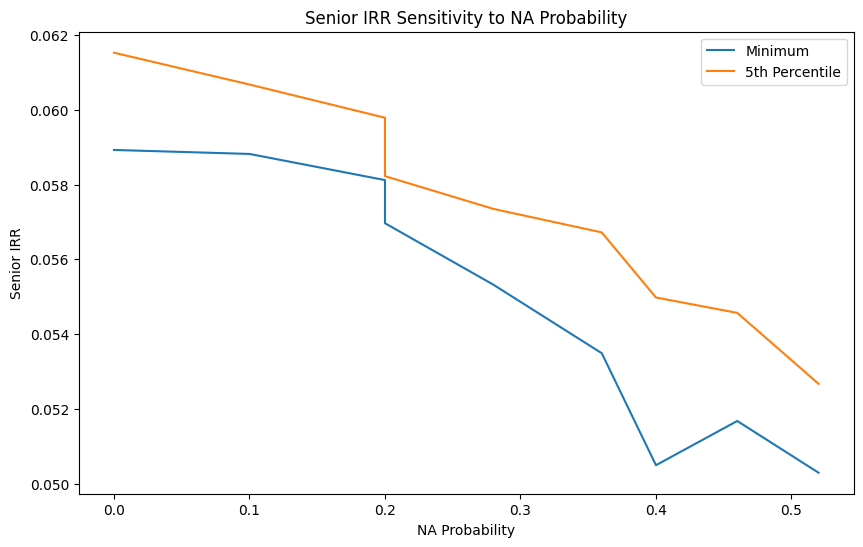

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(simulation_results_df['NA_prob'], simulation_results_df['senior_min'], label='Minimum')
plt.plot(simulation_results_df['NA_prob'], simulation_results_df['senior_5th_percentile'], label='5th Percentile')
plt.xlabel('NA Probability')
plt.ylabel('Senior IRR')
plt.title('Senior IRR Sensitivity to NA Probability')
plt.legend()
plt.show()

In [ ]:
simulation_results_df[['NA_prob','Dur_senior','IRR_senior','senior_5th_percentile','senior_min']]

,NA_prob,Dur_senior,IRR_senior,senior_5th_percentile,senior_min
6,0.00,7.436696,0.066146,0.061525,0.058925
7,0.10,7.695568,0.064365,0.060674,0.058818
3,0.20,7.996026,0.063208,0.059787,0.058119
8,0.20,8.026066,0.063518,0.058224,0.056965
4,0.28,8.289620,0.061553,0.057348,0.055321
5,0.36,8.664734,0.061167,0.056720,0.053489
0,0.40,8.897485,0.060010,0.054979,0.050494
1,0.46,9.341292,0.059189,0.054568,0.051677
2,0.52,9.813783,0.057967,0.052671,0.050293


In [ ]:
simulation_results_df[['NA_prob','Dur_mezzanine','IRR_mezzanine']]

,NA_prob,Dur_mezzanine,IRR_mezzanine
6,0.00,10.540982,0.089138
7,0.10,11.077362,0.085145
3,0.20,11.727758,0.081733
8,0.20,11.773773,0.081363
4,0.28,12.334009,0.078440
5,0.36,13.097942,0.074792
0,0.40,13.629832,0.072348
1,0.46,14.596025,0.062500
2,0.52,15.328093,0.035857


In [ ]:
simulation_results_df[['NA_prob','Dur_remainder','IRR_remainder']]

,NA_prob,Dur_remainder,IRR_remainder
6,0.00,13.694042,0.174306
7,0.10,13.981001,0.154800
3,0.20,14.358795,0.131436
8,0.20,14.392706,0.130368
4,0.28,14.751982,0.107458
5,0.36,15.259790,0.077581
0,0.40,15.542461,0.051814
1,0.46,12.847475,-0.035871
2,0.52,9.797324,-0.330260


In [ ]:
simulation_results_df[['NA_prob','Dur','IRR']]

,NA_prob,Dur,IRR
6,0.00,10.942138,0.103608
7,0.10,10.943533,0.093673
3,0.20,10.940476,0.083052
8,0.20,10.953402,0.082703
4,0.28,10.947525,0.073467
5,0.36,10.946027,0.063460
0,0.40,10.939417,0.056841
1,0.46,10.949225,0.046666
2,0.52,10.966841,0.036626


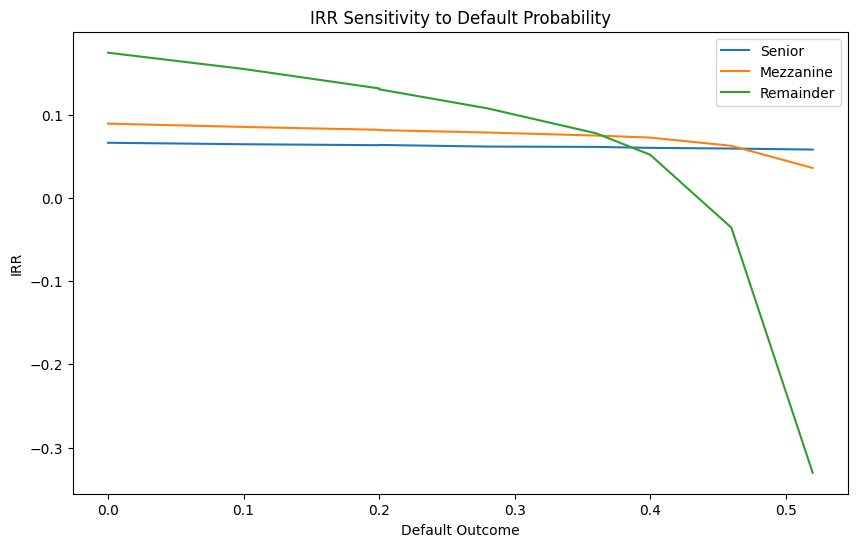

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(simulation_results_df['NA_prob'], simulation_results_df['IRR_senior'], label='Senior')
plt.plot(simulation_results_df['NA_prob'], simulation_results_df['IRR_mezzanine'], label='Mezzanine')
plt.plot(simulation_results_df['NA_prob'], simulation_results_df['IRR_remainder'], label='Remainder')
plt.xlabel('Default Outcome')
plt.ylabel('IRR')
plt.title('IRR Sensitivity to Default Probability')
plt.legend()
plt.show()


In [ ]:
num_years = 25
year = Year(initial_gdp_growth=.01, initial_inflation_rate=.02, initial_unemployment_rate=.04,initial_isa_cap=120000,initial_isa_threshold=27000,
            num_years=num_years,senior_debt_threshold=3000000,mezzanine_debt_threshold=1000000)
for _ in range(num_years):
    print(f'Deflator: {year.deflator},GDP Growth: {year.gdp_growth}, Inflation Rate: {year.inflation_rate}, UER: {year.unemployment_rate}, Mezz_thresh:{year.mezzanine_debt_threshold}')
    year.next_year()

Deflator: 1,GDP Growth: 0.01, Inflation Rate: 0.02, UER: 0.04, Mezz_thresh:1000000
Deflator: 1.0121580213684775,GDP Growth: 0.017855853017250345, Inflation Rate: 0.012158021368477505, UER: 0.04732463436020383, Mezz_thresh:1012158.0213684775
Deflator: 1.0120044802768642,GDP Growth: 0.027595053704198767, Inflation Rate: -0.0001516967591736959, UER: 0.028156746173541258, Mezz_thresh:1012004.4802768643
Deflator: 1.025726066217093,GDP Growth: 0.012579045544350848, Inflation Rate: 0.013558819360636645, UER: 0.026791152488820556, Mezz_thresh:1025726.0662170933
Deflator: 1.0370351833362856,GDP Growth: 0.006442266137766985, Inflation Rate: 0.01102547501878426, UER: 0.024809585362177818, Mezz_thresh:1037035.1833362858
Deflator: 1.0507331959811634,GDP Growth: -0.03198308413316205, Inflation Rate: 0.0132088215182916, UER: 0.03139395693984598, Mezz_thresh:1050733.1959811635
Deflator: 1.0862526917471025,GDP Growth: 0.03049533976363631, Inflation Rate: 0.033804486145287804, UER: 0.02410473686298606, 

In [ ]:
ern_df = pd.DataFrame(list(df_list[0]['Earnings']),columns = range(num_years))
pay_df = pd.DataFrame(list(df_list[0]['Payments']),columns = range(num_years))

In [ ]:
df = pd.melt(df, id_vars=['Student', 'Degree'], value_vars=[f'Year_{i+1}_Payment' for i in range(num_years)],
             var_name='Year', value_name='Payment')

# Convert the 'Year' column to integers for easier analysis
df['Year'] = df['Year'].str.extract('(\d+)').astype(int)

0.09285714285714286

In [ ]:
pd.DataFrame(df_list[0]['Payments'][0])


,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,9310.688847
5,9613.806964
6,9960.115832
7,10391.144724
8,10762.622967
9,11148.537780


In [ ]:
for i in range(25):
  print(f'year: {i+1}')
  print(ern_df[i].describe())

year: 1
count    120.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: 0, dtype: float64
year: 2
count    120.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: 1, dtype: float64
year: 3
count    120.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: 2, dtype: float64
year: 4
count    120.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: 3, dtype: float64
year: 5
count      120.000000
mean     20925.180481
std      22798.930431
min          0.000000
25%          0.000000
50%       3507.908807
75%      47249.908283
max      47657.202043
Name: 4, dtype: float64
year: 6
count      120.000000
mean     22175.002448
std      23610.678647
min          0.000000
25%          0.000000
50%       3810.797585
75%      49011.137476
max      49433.613015


0.06567795363890705

In [ ]:
what_am_i = np.sum(ern_df.T)

what_am_i.describe()

#for i in range(120):
 # print(what_am_i[i])

count    1.200000e+02
mean     1.157490e+06
std      7.935404e+05
min      1.251989e+04
25%      1.254327e+05
50%      1.635683e+06
75%      1.830214e+06
max      1.915046e+06
dtype: float64

In [ ]:
ern_df.T

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,45543.534294,2382.621516,2326.835730,0.000000,46951.831020,45220.729310,0.000000,46433.686973,2509.482138,2436.453331,...,50330.398504,0.000000,46522.275424,45074.107488,45698.777352,0.000000,44146.025030,47637.833493,2006.464983,0.000000
5,46506.002311,2432.973274,2376.008571,0.000000,47944.060463,46176.375514,0.000000,47414.966518,2562.514831,2487.942712,...,51394.026954,0.000000,47505.427102,46026.655144,46664.526108,0.000000,45078.959590,48644.560174,2048.867454,0.000000
6,48641.301984,2544.682016,2485.101808,55623.839223,50145.387852,48296.540539,2341.286025,49592.000825,2680.171409,2602.175349,...,53753.757817,4386.800977,49686.614861,48139.945834,48807.104322,54745.875595,47148.737316,50878.050654,2142.940171,55107.830124
7,51296.948050,2683.612812,2620.779731,58951.107102,52883.151780,50933.363828,2481.335434,52299.551745,2826.499455,2744.245081,...,56688.526207,4649.207567,52399.331378,50768.219597,51471.802620,0.000000,49722.894538,53655.815426,2259.937258,58404.231732
8,53007.563045,2773.104068,0.000000,61218.536822,0.000000,52631.854268,2576.774756,54043.600871,2920.755596,2835.758260,...,58578.935805,4828.029508,54146.707886,52461.202922,53188.248543,58484.570646,51381.019089,55445.092291,2335.300076,60650.627047
9,55214.147666,2888.542100,2683.999914,64082.603508,54158.834160,0.000000,2697.327371,56293.313397,3042.340026,2953.804444,...,61017.444038,5053.905512,56400.712524,54645.043810,55402.354691,61220.730626,53519.894374,57753.145726,2432.513321,63488.124469
